# Urban Sound Challenge
# 3. Evaluating Models



In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import pycm
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from src.utils import load_data, extract_features
from src.models import MLPModel, CNNModel, LSTMModel, RNNModel, GRUModel

Using TensorFlow backend.


In [17]:
%matplotlib inline

In [2]:
MODELS = {m.__name__: m for m in [MLPModel, CNNModel, LSTMModel, RNNModel, GRUModel]}
# 

In [3]:
classes = [
    'air_conditioner',
    'car_horn',
    'children_playing',
    'dog_bark',
    'drilling',
    'engine_idling',
    'gun_shot',
    'jackhammer',
    'siren',
    'street_music'
]
class_mapping = {i: c for i, c in enumerate(classes)}

## 3.1 Load Resources

### 3.1.1 Load test data

Final evaluation of models will be done on dedicated test data which was never used for training.

In [4]:
data_dir = Path('./data/raw')
data = load_data(data_dir, "test.csv", "test_cached.pkl")
print(f"{len(data)} samples loaded!")

Loading cached data!
33 samples loaded!


### 3.1.2 Load models

In [5]:
MODELS_DIR = Path('./models')
available_model_weights = [m for m in os.listdir(MODELS_DIR) if m.endswith('.h5')]

In [6]:
available_model_weights

['CNNModel.h5',
 'GRUModel.h5',
 'LSTMModel.h5',
 'MLPModel.h5',
 'MLP_v1.h5',
 'RNNModel.h5']

In [7]:
models = []
for weights_name in available_model_weights:
    model_name = Path(weights_name).stem
    if model_name in MODELS:
        print(f"Loading weights for {model_name}: {weights_name}")
        m = MODELS[model_name].create(len(classes))
        m.load_weights(MODELS_DIR/weights_name)
        models.append((MODELS[model_name], m))

Loading weights for CNNModel: CNNModel.h5
Loading weights for GRUModel: GRUModel.h5
Loading weights for LSTMModel: LSTMModel.h5
Input shape: (174, 40)
Loading weights for MLPModel: MLPModel.h5
Loading weights for RNNModel: RNNModel.h5
Input shape: (174, 40)


## 3.2 Run predictions on each model

### 3.2.1 Extract features

In [8]:
def preprocess_features(df, cache_name: str=None, **kwargs):
    CACHE_DIR = Path('./data/interim/')
    if cache_name is None:  # create default cache name
        dim = str(kwargs.get('output_ndim', 2))+"d"
        pad_mode = kwargs.get('pad_mode', 'constant')
        cache_name = f"_prepped_{dim}_{pad_mode}.pkl"
        
    if os.path.exists(CACHE_DIR/cache_name):
        print(f"Loading cached data!")
        return pd.read_pickle(CACHE_DIR/cache_name)
    df_extracted = df.apply(lambda x: extract_features(x.raw, x.sample_rate, **kwargs), axis=1)
    
    df = pd.concat([df, df_extracted], axis=1)
    if cache_name is not None:
        print(f"Saved prepped data to '{cache_name}'")
        df.to_pickle(CACHE_DIR/cache_name)
    return df

In [9]:
df = preprocess_features(data, "test_data", max_pad=174)

Loading cached data!


In [10]:
df.head()

,ID,Class,raw,sample_rate,duration,features,n_mfccs,n_frames,n_samples
0,60,siren,"[-0.1501603, -0.22697054, -0.18564214, -0.1575...",22050,4.0,"[[-85.74231, -97.987305, -149.24211, -144.3163...",40,174,88200
1,68,dog_bark,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,4.0,"[[-522.5737, -386.47192, -295.27643, -248.5259...",40,174,88200
2,1001,air_conditioner,"[-0.0244173, -0.08245073, -0.150833, -0.180281...",22050,4.0,"[[-47.746044, -41.07793, -43.417732, -44.52945...",40,174,88200
3,1004,air_conditioner,"[-0.02486453, -0.030850401, -0.026526619, -0.0...",22050,4.0,"[[-246.2536, -236.39981, -235.75073, -242.3951...",40,174,88200
4,1006,jackhammer,"[0.016366571, 0.045260947, 0.055535704, 0.0412...",22050,4.0,"[[-127.11581, -134.37817, -149.66733, -86.7684...",40,174,88200


Prepare data for usage by converting features and corresponding classification labels into numpy arrays and One-Hot encoding the labels

In [11]:
x = np.array(df.features.tolist())
y = np.array([classes.index(c) for c in df.Class.tolist()])

# # Encode the classification labels
# le = LabelEncoder()
# y_1h = to_categorical(le.fit_transform(y))

### 3.2.2 Make prediction

In [12]:
cms = {}
metrics = []

for model_cls, model in models:
    _x = model_cls.reshape_data(x)
    y_pred = model.predict_classes(_x)
    cm = pycm.ConfusionMatrix(actual_vector=y, predict_vector=y_pred)
    cm.relabel(class_mapping)
    cms[model.name] = cm
    
    # save relevant metrics for later comparison
    metrics.append({
        'model': model.name, 
        'Accuracy': cm.overall_stat['Overall ACC'],
        'F1-Micro': cm.overall_stat['F1 Micro'],
        'Kappa': cm.overall_stat['Kappa']
        })

In [13]:
def plot_confusion_matrix(cm,normalize=False,title='Confusion matrix',annot=False,cmap="YlGnBu"):
    if normalize == True:
        df = pd.DataFrame(cm.normalized_matrix).T.fillna(0)
    else:
        df = pd.DataFrame(cm.matrix).T.fillna(0)
        
    ax = sns.heatmap(df,annot=annot,cmap=cmap)
    ax.set_title(title)
    ax.set(xlabel='Predict', ylabel='Actual')
    ax.figure.subplots_adjust(bottom = 0.2)

In [ ]:
plot_confusion_matrix(cms['RNN'],title="rnn",annot=True)

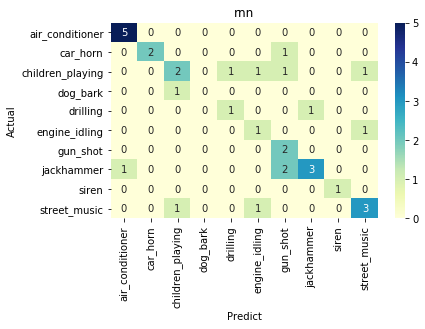

In [21]:
pd.DataFrame(metrics)

In [15]:
pd.DataFrame(metrics)

,model,Accuracy,F1-Micro,Kappa
0,CNN,0.848485,0.848485,0.825766
1,GRU,0.757576,0.757576,0.725857
2,LSTM,0.757576,0.757576,0.725857
3,MLP,1.000000,1.000000,1.000000
4,RNN,0.606061,0.606061,0.551724
